In [1]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import pandas as pd

rootFolder = os.getcwd()
os.chdir(rootFolder)
print(rootFolder)
folder = os.listdir('morphologies/')

savedata = 1 # Save Netpyne and BBP soma_voltage

/home/fernando/Dropbox/Human_L23_NetPyNE


In [2]:
folder = [fldr[0:-4] for fldr in folder]
folder

['HL23SST', 'HL23VIP', 'HL23PYR', 'HL23PV']

In [4]:
# !nrnivmodl mod/

In [5]:
from netpyne import sim, specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = 2000 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -80}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},                  
                    'V_dend_5': {'sec':'dend_5', 'loc':0.5, 'var':'v'},
                    }


## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025      

cfg.simLabel = 'S1_Net'
cfg.saveFolder = '.'
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData' , 'simConfig', 'netParams', 'netParams']
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = True		##  

cfg.analysis['plotTraces'] = {'include': allpops, 'figSize': (12, 4), 'timeRange': [0,cfg.duration], 'saveFig': False, 'overlay': True, 'oneFigPer': 'cell'}  # Plot recorded traces for this list of cells


#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 0

cfg.IClamp1 = {'pop': 'HL23PYR',  'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': 100, 'amp': 0.1}
# cfg.IClamp2 = {'pop': 'HL23VIP', 'sec': 'soma_0', 'loc': 0.5, 'start': 100, 'dur': 300, 'amp': 0.1}
# cfg.IClamp3 = {'pop': 'HL23PV', 'sec': 'soma_0', 'loc': 0.5, 'start': 100, 'dur': 300, 'amp': 0.1}
# cfg.IClamp4 = {'pop': 'HL23SST', 'sec': 'soma_0', 'loc': 0.5, 'start': 100, 'dur': 300, 'amp': 0.1}

In [5]:
#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------
netParams = specs.NetParams()   # object of class NetParams to store the network parameters
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 950.0
cfg.sizeX = 50.0 # r = ??? um
cfg.sizeZ = 50.0

netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
cellModels = ['HH_full']

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------

for cellName in allpops:
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=True,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper.py',
        cellName='loadCell_' + cellName,
        cellInstance = True,
        cellArgs={'cellName': cellName})

NeuronTemplate_HL23PYR[0]
NeuronTemplate_HL23VIP[0]
NeuronTemplate_HL23PV[0]
NeuronTemplate_HL23SST[0]


## Load cells and circuit informations from table

In [6]:
#Import Excel file
circuit_params = pd.read_excel('Circuit_param.xls', sheet_name = None, index_col = 0)

#Get cell names and import biophys
cell_names = [i for i in circuit_params['conn_probs'].axes[0]]

circuit_params["syn_params"] = {'none':{'tau_r_AMPA': 0,'tau_d_AMPA': 0,'tau_r_NMDA': 0,
                                'tau_d_NMDA': 0, 'e': 0,'Dep': 0,'Fac': 0,'Use': 0,'u0':0,'gmax': 0}}
circuit_params["multi_syns"] = {'none':{'loc':0,'scale':0}}
# organizing dictionary for LFPY input
for pre in cell_names:
    for post in cell_names:
        if "PYR" in pre:
            circuit_params["syn_params"][pre+post] = {'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3, 'tau_r_NMDA': 2,
                                                      'tau_d_NMDA': 65, 'e': 0, 'u0':0,
                                                      'Dep': circuit_params["Depression"].at[pre, post],
                                                      'Fac': circuit_params["Facilitation"].at[pre, post],
                                                      'Use': circuit_params["Use"].at[pre, post],
                                                      'gmax': circuit_params["syn_cond"].at[pre, post]}
        else:
            circuit_params["syn_params"][pre+post] = {'tau_r': 1, 'tau_d': 10, 'e': -80, 'u0':0,
                                                      'Dep': circuit_params["Depression"].at[pre, post],
                                                      'Fac': circuit_params["Facilitation"].at[pre, post],
                                                      'Use': circuit_params["Use"].at[pre, post],
                                                      'gmax': circuit_params["syn_cond"].at[pre, post]}
        circuit_params["multi_syns"][pre+post] = {'loc':int(circuit_params["n_cont"].at[pre, post]),'scale':0}


stimuli = []
for stimulus in circuit_params['STIM_PARAM'].axes[0]:
    stimuli.append({})
    for param_name in circuit_params['STIM_PARAM'].axes[1]:
        stimuli[-1][param_name] = circuit_params['STIM_PARAM'].at[stimulus, param_name]
    new_param = circuit_params["syn_params"][stimuli[-1]['syn_params']].copy()
    new_param['gmax'] = stimuli[-1]['gmax']
    stimuli[-1]['new_param'] = new_param

In [7]:
circuit_params.keys()

dict_keys(['conn_probs', 'syn_cond', 'n_cont', 'Depression', 'Facilitation', 'Use', 'Syn_pos', 'SING_CELL_PARAM', 'STIM_PARAM', 'syn_params', 'multi_syns'])

In [8]:
circuit_params['SING_CELL_PARAM']

,HL23PYR,HL23SST,HL23PV,HL23VIP
GOU,0.000028,0.000030,0.000280,0.000066
norm_tonic,0.000938,0.000938,0.000938,0.000938
drug_tonic,0.001352,0.001030,0.001091,0.000938
apic_tonic,0.000938,0.000938,0.000938,0.000938
drug_apic_tonic,0.001352,0.001030,0.001091,0.000938
cell_num,800.000000,50.000000,70.000000,80.000000
rotate_x,1.570000,1.770000,1.260000,-1.570000
rotate_y,2.620000,2.770000,2.570000,3.570000


## Rotate the cells -> Vertical axis

In [9]:
rotate_x = {}
rotate_y = {}
rotate_z = {}
rotate_x['HL23PYR'], rotate_x['HL23SST'], rotate_x['HL23PV'], rotate_x['HL23VIP'] = 1.57+1.5708, 1.77+1.5708, 1.26+1.5708, -1.57+1.5708
rotate_y['HL23PYR'], rotate_y['HL23SST'], rotate_y['HL23PV'], rotate_y['HL23VIP'] = 2.62, 2.77, 2.57, 3.57
rotate_z['HL23PYR'], rotate_z['HL23SST'], rotate_z['HL23PV'], rotate_z['HL23VIP'] = 0.0, 0.0, 0.0, 0.0


for cellName in netParams.cellParams.keys():

    cellType = netParams.cellParams[cellName]['conds']['cellType']

    x = rotate_x[cellType]
    y = rotate_y[cellType]
    z = rotate_z[cellType]

    for sectName in netParams.cellParams[cellName]['secs'].keys():

        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        theta = -x
        rotation_x = np.array([[1, 0, 0],
                                       [0, np.cos(theta), -np.sin(theta)],
                                       [0, np.sin(theta), np.cos(theta)]])
        
        # print(cellName,sectName,len(sectParams_new))
        # print(sectParams_new)       
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_x)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        phi = -y
        rotation_y = np.array([[np.cos(phi), 0, np.sin(phi)],
                                       [0, 1, 0],
                                       [-np.sin(phi), 0, np.cos(phi)]])
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_y)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        gamma = -z
        rotation_z = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                                       [np.sin(gamma), np.cos(gamma), 0],
                                       [0, 0, 1]])
    
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_z)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams

## Change axon names

In [10]:
#------------------------------------------------------------------------------
# Cell parameters 
#------------------------------------------------------------------------------

for cellName in netParams.cellParams.keys():
        
        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['soma_0']['geom']['pt3d'][-1]
        axon_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellName]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['pt3d'][-1]
        axon1_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellName]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        
        if 'myelin_0' in netParams.cellParams[cellName]['secs'].keys():

                if 'myelin_0' not in netParams.cellParams[cellName]['secLists']['all']:
                        netParams.cellParams[cellName]['secLists']['all'].append('myelin_0')

                if 'myelin_0' not in netParams.cellParams[cellName]['secLists']['axonal']:                        
                        netParams.cellParams[cellName]['secLists']['axonal'].append('myelin_0')

                myelin0_pt3d_x, myelin0_pt3d_y, myelin0_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['pt3d'][-1]
                myelin0_pt3d_diam =  netParams.cellParams[cellName]['secs']['myelin_0']['geom']['diam']
                myelin0_pt3d_L =  netParams.cellParams[cellName]['secs']['myelin_0']['geom']['L']

                netParams.cellParams[cellName]['secs']['myelin_0']['geom']['pt3d'] = [(myelin0_pt3d_x, myelin0_pt3d_y, myelin0_pt3d_z, myelin0_pt3d_diam),
                                                                                (myelin0_pt3d_x, myelin0_pt3d_y+myelin0_pt3d_L/2.0, myelin0_pt3d_z, myelin0_pt3d_diam),
                                                                                (myelin0_pt3d_x, myelin0_pt3d_y+myelin0_pt3d_L, myelin0_pt3d_z, myelin0_pt3d_diam)] 
# print and rename
for cellName in netParams.cellParams.keys():

    netParams.renameCellParamsSec(label=cellName, oldSec='myelin_0', newSec='axon_2')      
           
    for secname2 in netParams.cellParams[cellName]['secLists'].keys():
     if 'myelin_0' in netParams.cellParams[cellName]['secLists'][secname2]:
       print('old ->',cellName,secname2,netParams.cellParams[cellName]['secLists'][secname2][-1])
       netParams.cellParams[cellName]['secLists'][secname2][-1] = 'axon_2'    
       print('new ->',cellName,secname2,netParams.cellParams[cellName]['secLists'][secname2][-1])

old -> HL23PYR_rule all myelin_0
new -> HL23PYR_rule all axon_2
old -> HL23PYR_rule axonal myelin_0
new -> HL23PYR_rule axonal axon_2
old -> HL23SST_rule all myelin_0
new -> HL23SST_rule all axon_2
old -> HL23SST_rule axonal myelin_0
new -> HL23SST_rule axonal axon_2


In [11]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
# cell_num = [800, 50, 70, 80]
cell_num = [19, 2, 2, 2]

for ii,cellName in enumerate(['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']):
    netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': cell_num[ii]} 

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

        
# netParams.rotateCellsRandomly = True

## Create Network

In [12]:
circuit_params.keys()

dict_keys(['conn_probs', 'syn_cond', 'n_cont', 'Depression', 'Facilitation', 'Use', 'Syn_pos', 'SING_CELL_PARAM', 'STIM_PARAM', 'syn_params', 'multi_syns'])

In [13]:
# circuit_params['syn_params']

In [14]:
circuit_params['conn_probs']

,HL23PYR,HL23SST,HL23PV,HL23VIP
HL23PYR,0.150,0.19,0.09,0.09
HL23SST,0.190,0.04,0.20,0.06
HL23PV,0.094,0.05,0.37,0.03
HL23VIP,0.000,0.35,0.10,0.05


In [15]:

# ['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']

# Synaptic mechanism parameters
netParams.synMechParams['AMPA'] = {'mod': 'Exp2Syn', 'tau1': 0.05, 'tau2': 5.3, 'e': 0}  # AMPA
netParams.synMechParams['NMDA'] = {'mod': 'Exp2Syn', 'tau1': 0.15, 'tau2': 15, 'e': 0}  # NMDA
netParams.synMechParams['GABAA'] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABAA
netParams.synMechParams['GABAB'] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABAB


# Stimulation parameters
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 1}
netParams.stimSourceParams['bkg2'] = {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 1}
netParams.stimTargetParams['bkg->PYR'] = {'source': 'bkg', 'conds': {'pop': 'HL23PYR'}, 'weight': 0.001, 'delay': 'uniform(1,5)'}
netParams.stimTargetParams['bkg->IN'] = {'source': 'bkg2', 'conds': {'pop': ['HL23SST', 'HL23PV', 'HL23VIP']}, 'weight': 0.001, 'delay': 'uniform(1,5)'}


# Connectivity parameters

# # Excitatory

netParams.connParams['HL23PYR->HL23PYR'] = {
    'preConds': {'pop': 'HL23PYR'}, 'postConds': {'pop': 'HL23PYR'},
    'weight': 0.001,                    # weight of each connection
    'synMech': 'AMPA',
    'delay': 0.5,     # 
    'probability': 0.2}    #


netParams.connParams['HL23PYR->HL23SST'] = {
    'preConds': {'pop': 'HL23PYR'}, 'postConds': {'pop': 'HL23SST'},
    'weight': 0.002,                    # weight of each connection
    'synMech': 'AMPA',
    'delay': 0.5,     # 
    'probability': 0.2}    #


netParams.connParams['HL23PYR->HL23PV'] = {
    'preConds': {'pop': 'HL23PYR'}, 'postConds': {'pop': 'HL23PV'},
    'weight': 0.005,                    # weight of each connection
    'synMech': 'AMPA',
    'delay': 0.5,     # 
    'probability': 0.5}    #


netParams.connParams['HL23PYR->HL23VIP'] = {
    'preConds': {'pop': 'HL23PYR'}, 'postConds': {'pop': 'HL23VIP'},
    'weight': 0.002,                    # weight of each connection
    'synMech': 'AMPA',
    'delay': 0.5,     # 
    'probability': 0.2}    #


# Inhibitory
netParams.connParams['HL23PV->HL23PYR'] = {
    'preConds': {'pop': 'HL23PV'}, 'postConds': {'pop': 'HL23PYR'},
    'weight': 0.005,                    # weight of each connection
    'synMech': 'GABAA',
    'delay': 0.5,     # 
    'probability': 1.0}    #


netParams.connParams['HL23PV->HL23SST'] = {
    'preConds': {'pop': 'HL23PV'}, 'postConds': {'pop': 'HL23SST'},
    'weight': 0.002,                    # weight of each connection
    'synMech': 'GABAA',
    'delay': 0.5,     # 
    'probability': 1.0}    #



In [16]:
# for i, pre in enumerate(['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']):
#     for j, post in enumerate(['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']):


        # 'L5_TPC:L5_TPC' ->  pre:post

        # #E2 -> syn 134
        # netParams.synMechParams['L5_TPC:L5_TPC'] = {'mod': 'ProbAMPANMDA', 'mod': 'ProbAMPANMDA',
        #                                           'Dep': ,
        #                                           'Fac': ,
        #                                           'Use': ,
        #                                           'tau_d_AMPA': ,
        #                                           'NMDA_ratio': }

        # if "PYR" in pre:
        #     circuit_params["syn_params"][pre+post] = {'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3, 'tau_r_NMDA': 2,
        #                                               'tau_d_NMDA': 65, 'e': 0, 'u0':0,
        #                                               'Dep': circuit_params["Depression"].at[pre, post],
        #                                               'Fac': circuit_params["Facilitation"].at[pre, post],
        #                                               'Use': circuit_params["Use"].at[pre, post],
        #                                               'gmax': circuit_params["syn_cond"].at[pre, post]}
        # else:
        #     circuit_params["syn_params"][pre+post] = {'tau_r': 1, 'tau_d': 10, 'e': -80, 'u0':0,
        #                                               'Dep': circuit_params["Depression"].at[pre, post],
        #                                               'Fac': circuit_params["Facilitation"].at[pre, post],
        #                                               'Use': circuit_params["Use"].at[pre, post],
        #                                               'gmax': circuit_params["syn_cond"].at[pre, post]}
        # circuit_params["multi_syns"][pre+post] = {'loc':int(circuit_params["n_cont"].at[pre, post]),'scale':0}




        # ## Cell connectivity rules
        # netParams.connParams['pre->post'] = { 
        #         'preConds': {'pop': 'presyn'},
        #         'postConds': {'pop': list(netParams.popParams.keys())[0:-1]},
        #         'sec': 'basal',                  # target postsyn section
        #         'synMech': 'L5_TPC:L5_TPC',              # target synaptic mechanism
        #         'weight': np.mean(connsinfo.get(connsinfo['@source_node']==172877)['conductance'].values),                 # synaptic weight 
        #         'synsPerConn': 6,
        #         'delay': 0.5}      

# for i, pre in enumerate(network.population_names):
#     for j, post in enumerate(network.population_names):
#         connectivity = network.get_connectivity_rand(
#                         pre=pre,
#                         post=post,
#                         connprob=0 if no_connectivity else circuit_params["conn_probs"].at[pre, post])
#         (conncount, syncount) = network.connect(
#                         pre=pre, post=post,
#                         connectivity=connectivity,
#                         syntype=E_syn if "PYR" in pre else I_syn,
#                         synparams=circuit_params["syn_params"][pre+post],
#                         weightfun=local_state.normal,
#                         weightargs={'loc':1, 'scale':0},
#                         minweight=1,
#                         delayfun=local_state.normal,
#                         delayargs={'loc':0.5, 'scale':0},
#                         mindelay=0.5,
#                         multapsefun=local_state.normal,
#                         multapseargs=circuit_params["multi_syns"][pre+post],

#                         syn_pos_args=syn_pos[circuit_params["Syn_pos"].at[pre,post]])


In [17]:
# netParams.addConnParams(None, {'preConds': {'cellType': ['IT','CT'], 'ynorm': [0.1,0.2]},
# 'postConds': {'cellType': 'IT', 'ynorm': [0.1,0.2]},
# 'synMech': 'AMPA',
# 'probability': 0.09263,
# 'weight': 0.64,
# 'delay': 'defaultDelay+dist_3D/propVelocity'})

# # Connectivity parameters
# netParams.connParams['HL23PYR->HL23PYR'] = {
#     'preConds': {'pop': 'HL23PYR'}, 'postConds': {'pop': 'HL23PYR'},
#     'weight': 0.002,                    # weight of each connection
#     'delay': '0.2+normal(13.0,1.4)',     # delay min=0.2, mean=13.0, var = 1.4
#     'threshold': 10,                    # threshold
#     'probability': 0.15907}    #

## Run 

In [18]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)


Start time:  2024-07-18 14:58:16.575826

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 25 
  Done; cell creation time = 0.68 s.
Making connections...
  Number of connections on node 0: 152 
  Done; cell connection time = 0.02 s.
Adding stims...
  Number of stims on node 0: 25 
  Done; cell stims creation time = 0.00 s.
Recording 100 traces of 4 types on node 0


{spkt: Vector[0], spkid: Vector[1], stims: {cell_0: {bkg: Vector[2]}, cell_1: {bkg: Vector[3]}, cell_2: {bkg: Vector[4]}, cell_3: {bkg: Vector[5]}, cell_4: {bkg: Vector[6]}, cell_5: {bkg: Vector[7]}, cell_6: {bkg: Vector[8]}, cell_7: {bkg: Vector[9]}, cell_8: {bkg: Vector[10]}, cell_9: {bkg: Vector[11]}, cell_10: {bkg: Vector[12]}, cell_11: {bkg: Vector[13]}, cell_12: {bkg: Vector[14]}, cell_13: {bkg: Vector[15]}, cell_14: {bkg: Vector[16]}, cell_15: {bkg: Vector[17]}, cell_16: {bkg: Vector[18]}, cell_17: {bkg: Vector[19]}, cell_18: {bkg: Vector[20]}, cell_19: {bkg2: Vector[21]}, cell_20: {bkg2: Vector[22]}, cell_21: {bkg2: Vector[23]}, cell_22: {bkg2: Vector[24]}, cell_23: {bkg2: Vector[25]}, cell_24: {bkg2: Vector[26]}}, V_soma: {cell_0: Vector[102], cell_1: Vector[105], cell_2: Vector[108], cell_3: Vector[111], cell_4: Vector[114], cell_5: Vector[117], cell_6: Vector[120], cell_7: Vector[123], cell_8: Vector[126], cell_9: Vector[129], cell_10: Vector[132], cell_11: Vector[135], cell

0.0s

Running simulation using NEURON for 2000.0 ms...
0.5s
1.0s
1.5s
2.0s
  Done; run time = 55.16 s; real-time ratio: 0.04.

Gathering data...
  Done; gather time = 0.56 s.

Analyzing...
  Cells: 25
  Connections: 177 (7.08 per cell)
  Spikes: 169 (3.38 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 55.16 s
   HL23PYR : 3.474 Hz
   HL23SST : 3.750 Hz
   HL23PV : 4.500 Hz
   HL23VIP : 1.000 Hz
Plotting recorded cell traces ... cell


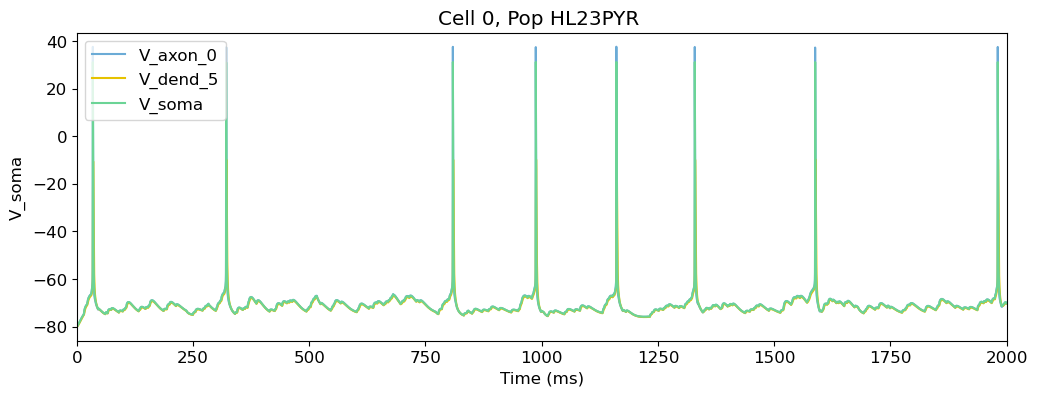

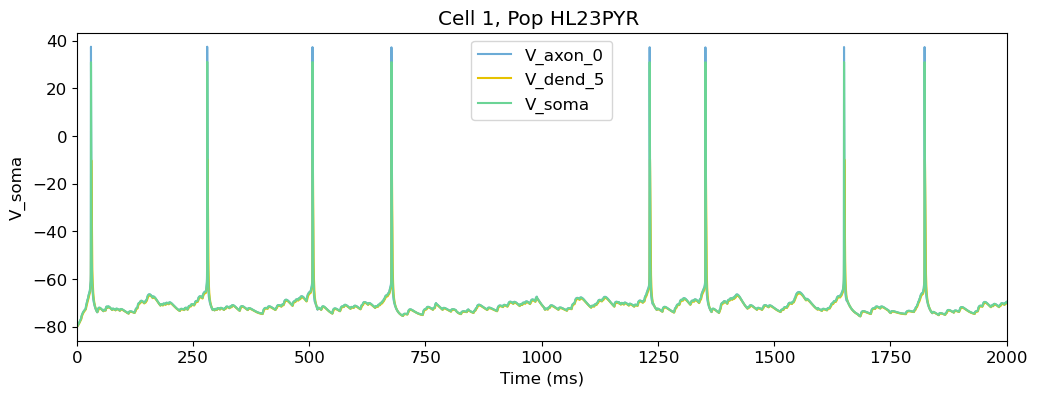

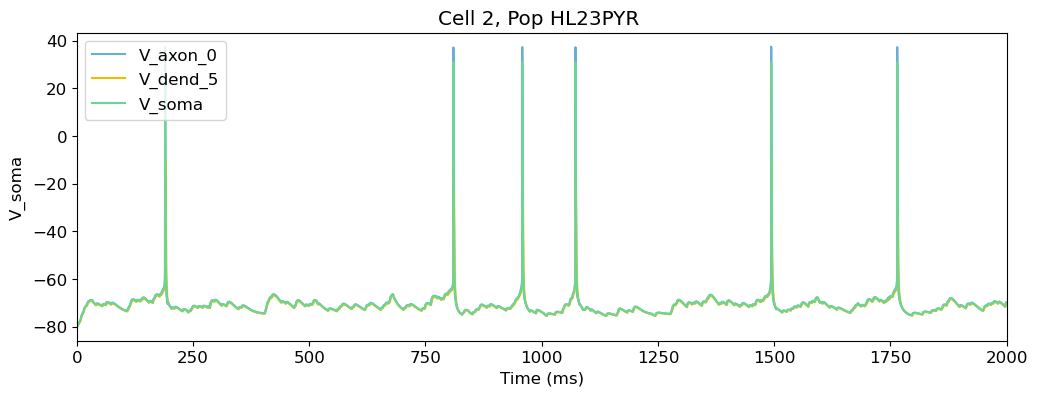

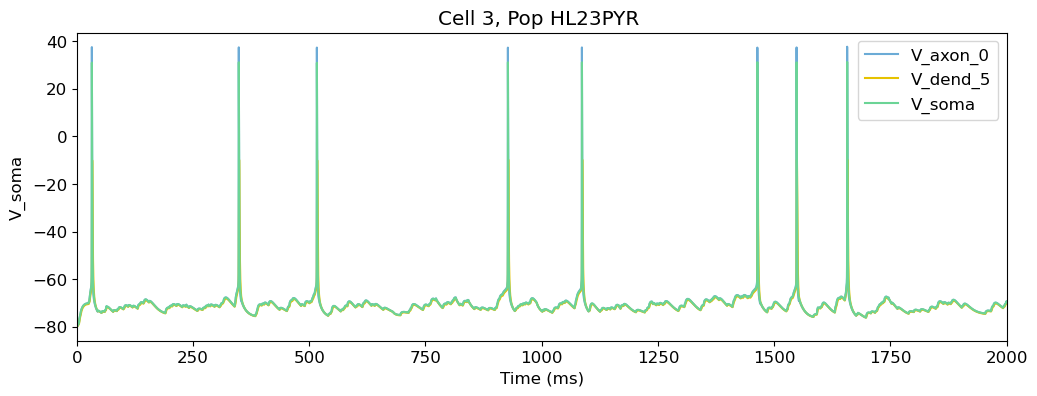

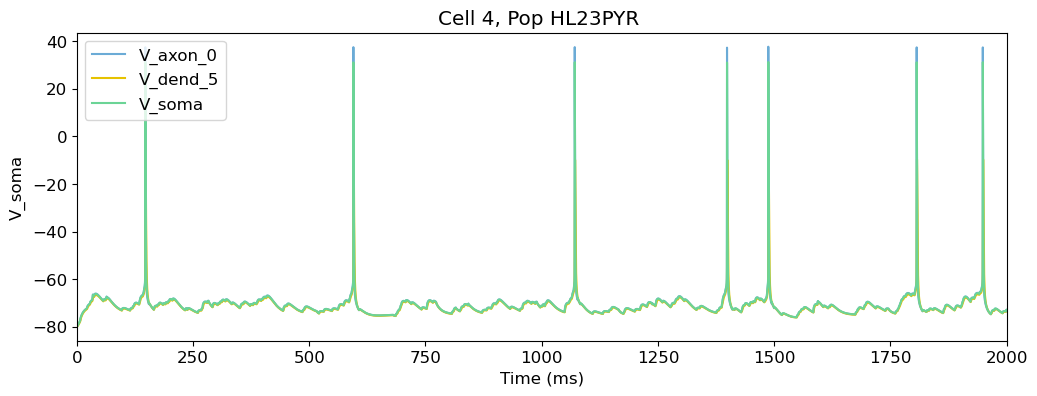

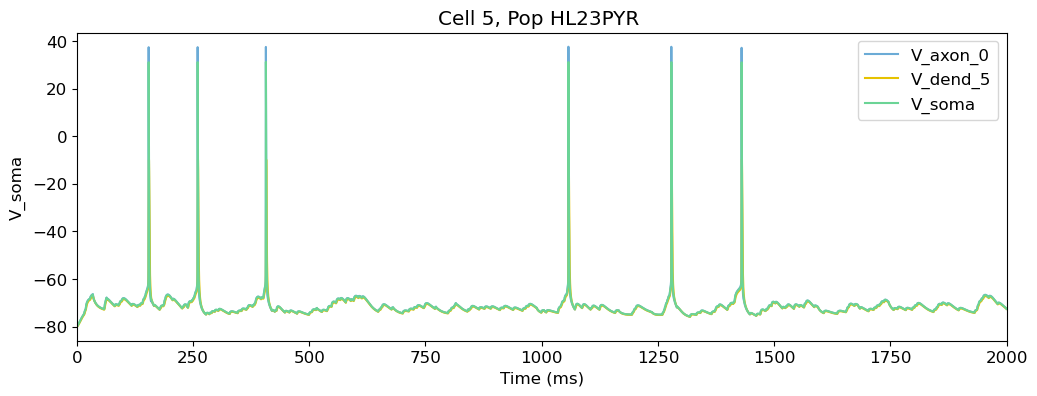

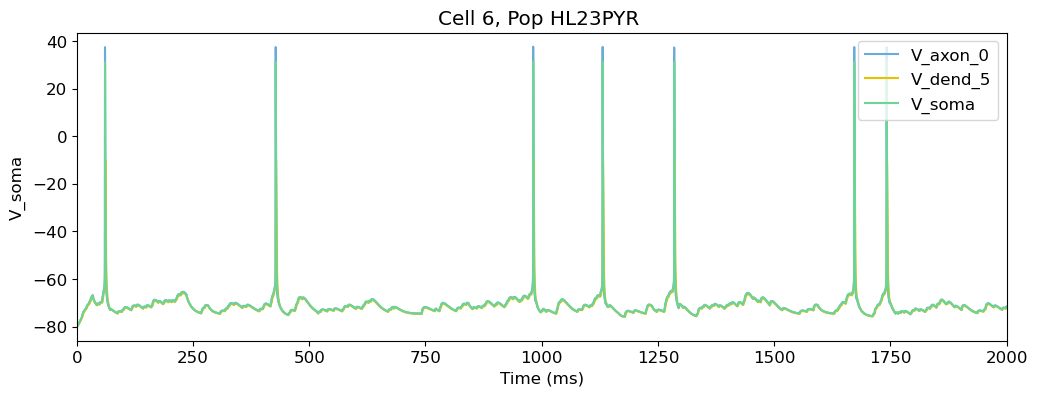

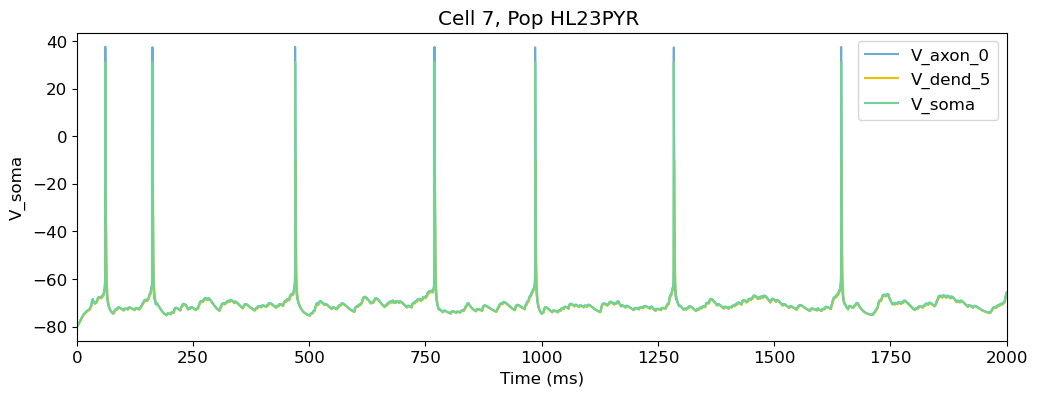

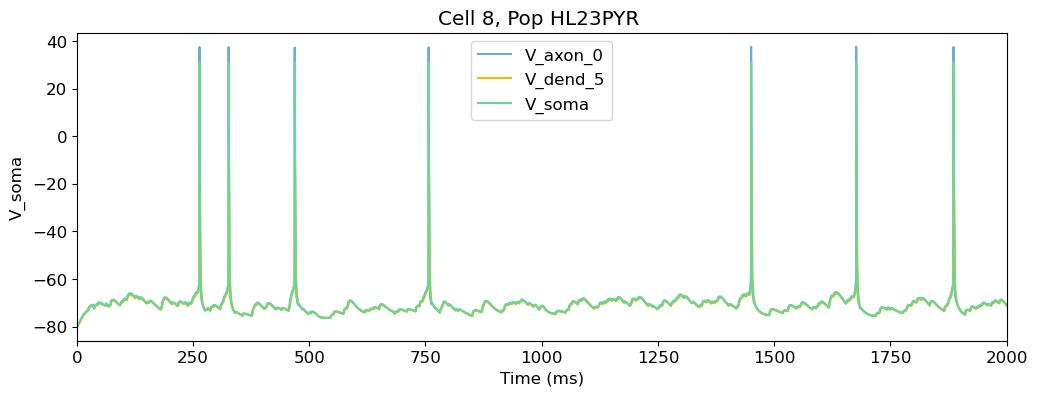

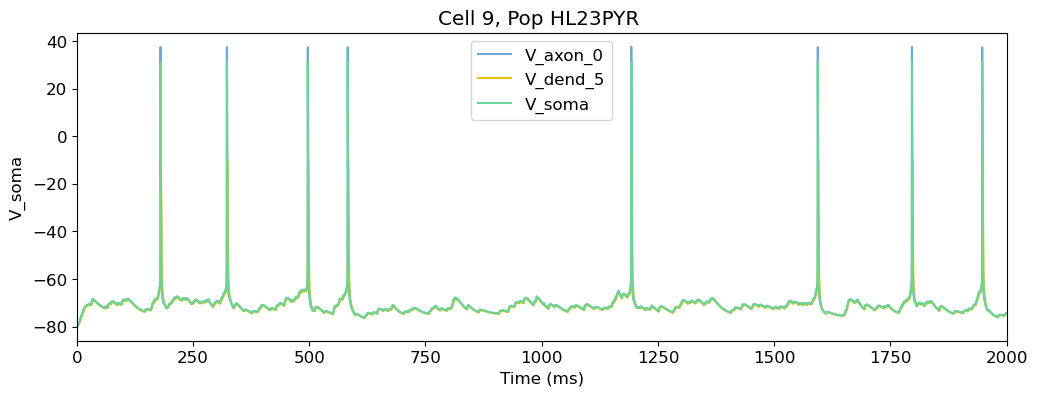

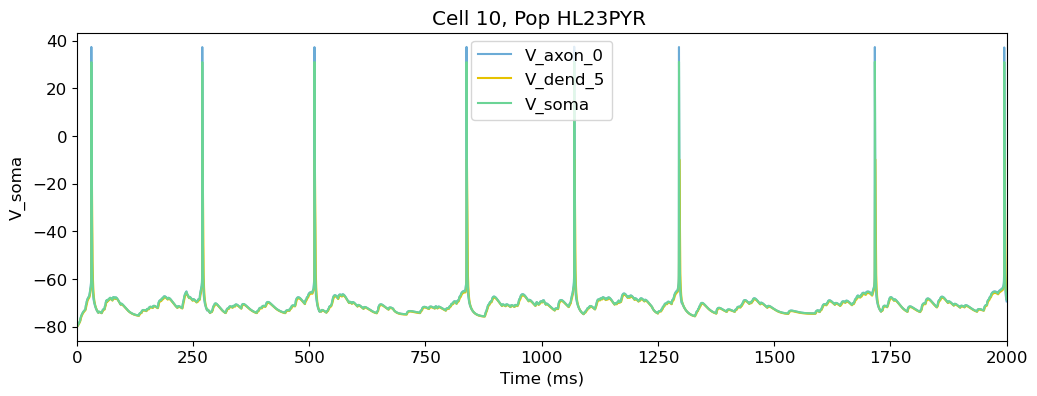

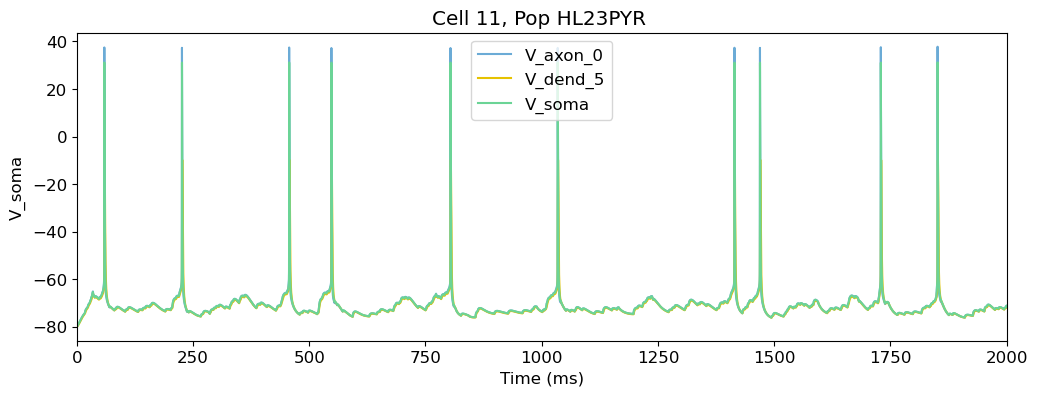

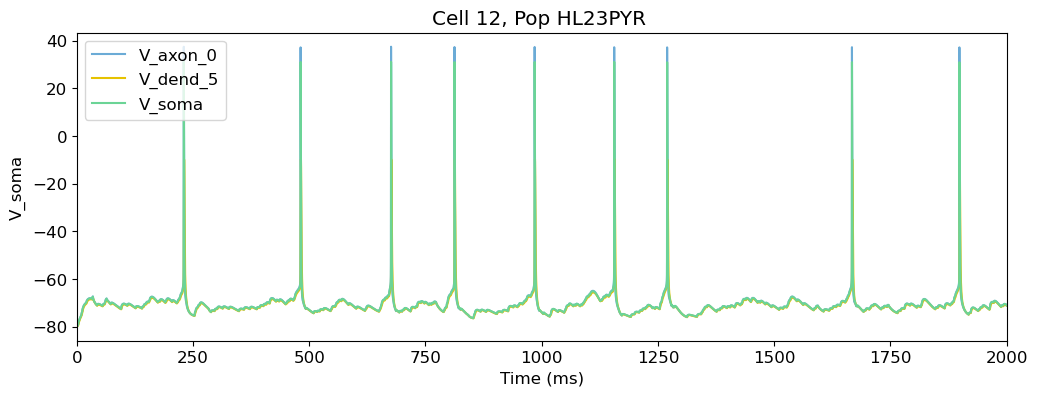

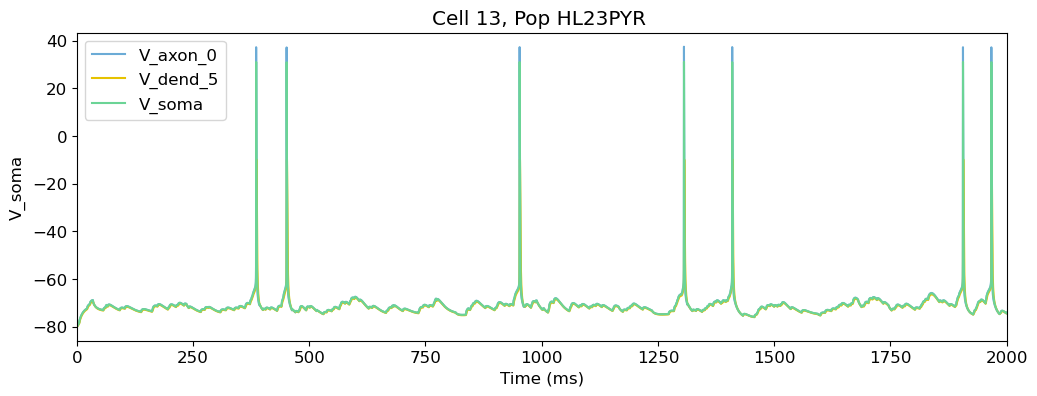

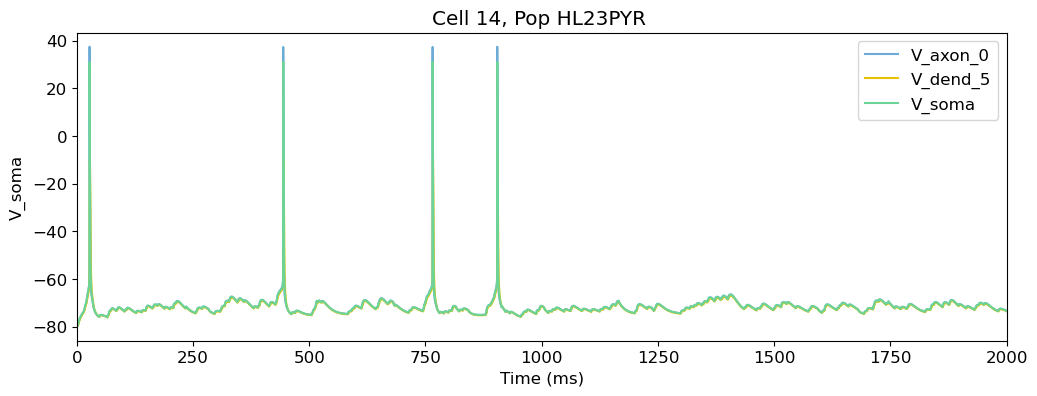

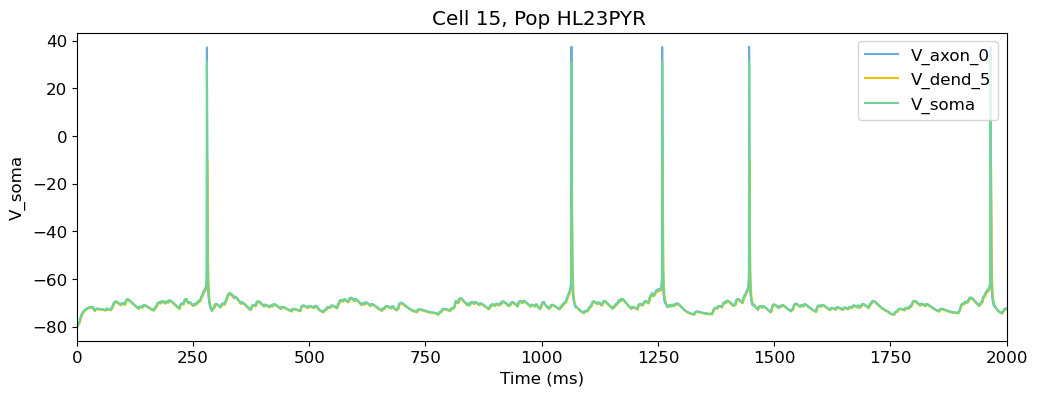

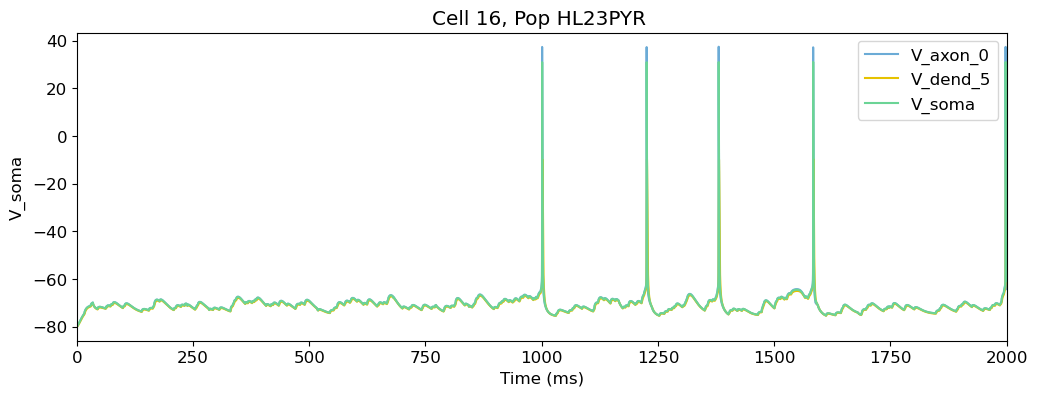

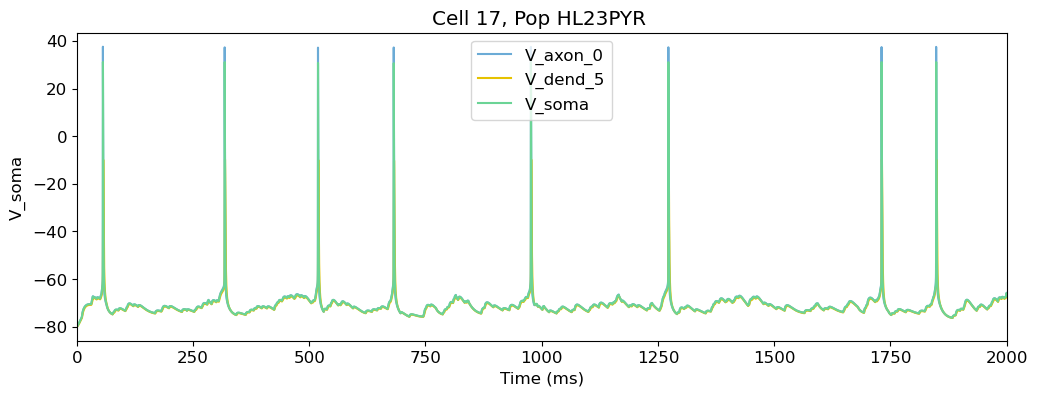

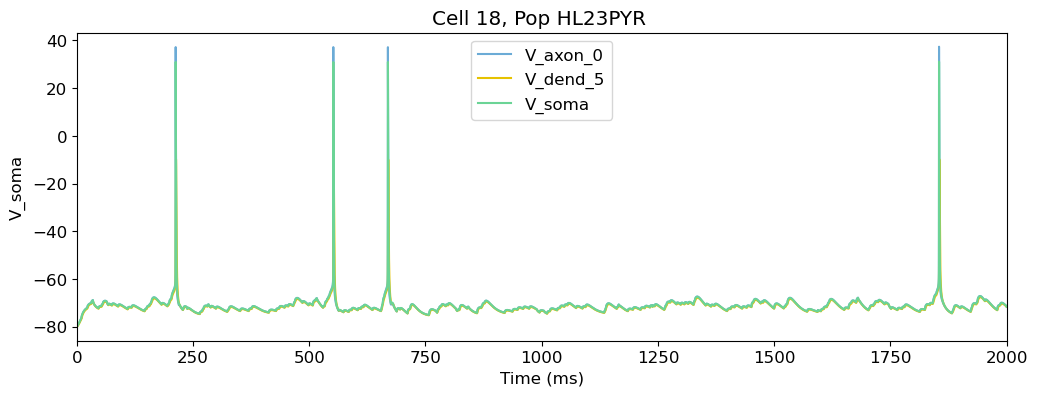

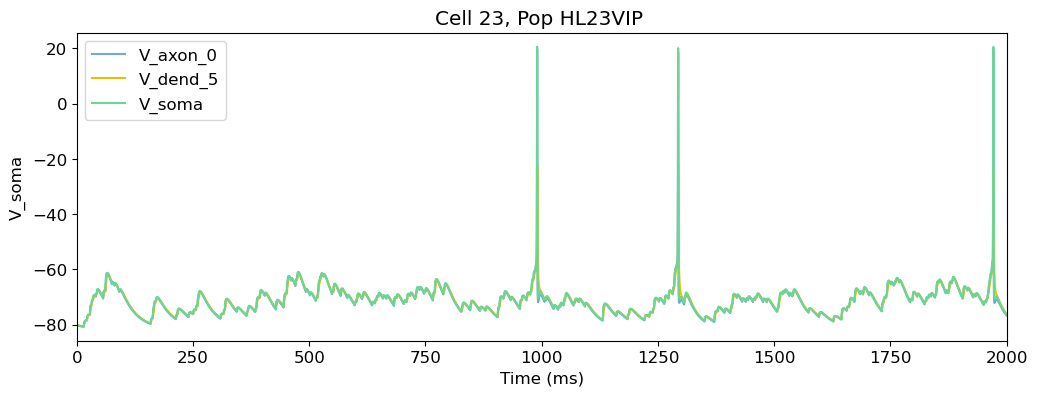

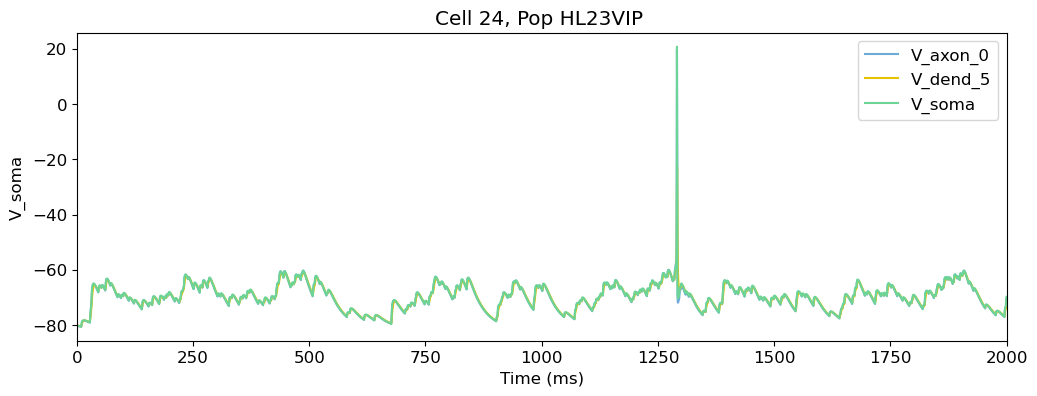

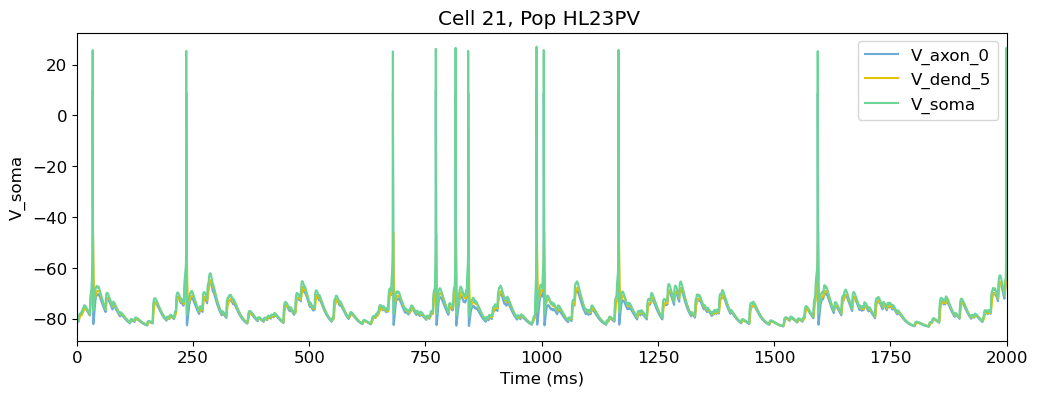

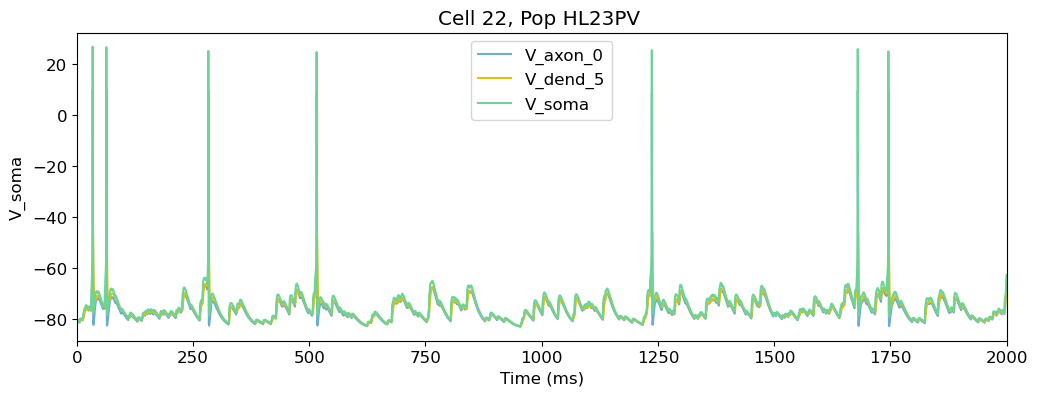

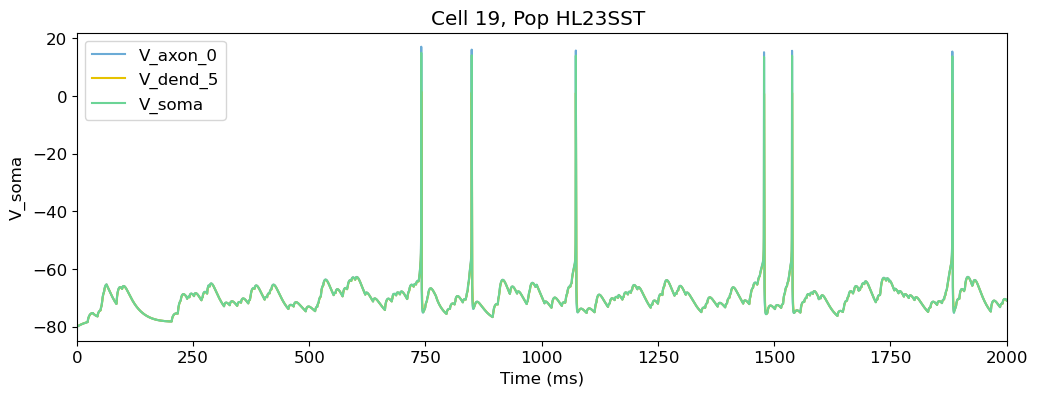

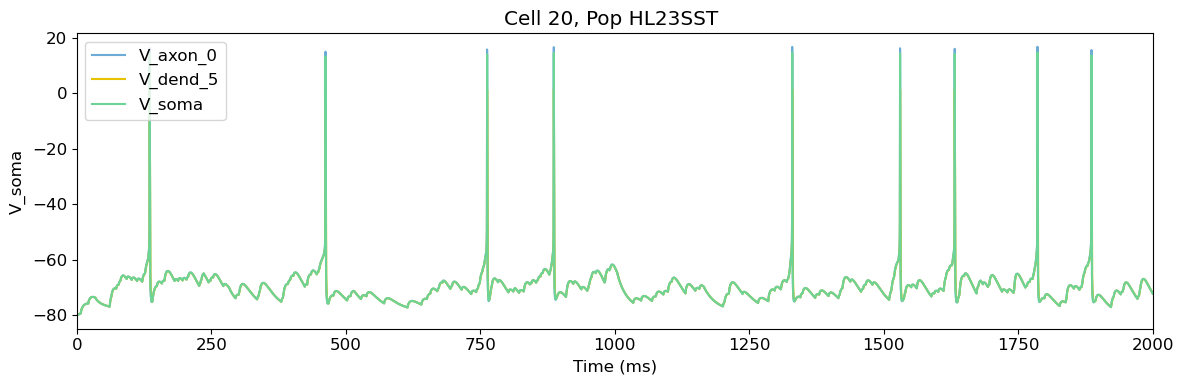

  Done; plotting time = 13.05 s

Total time = 69.53 s
Plotting 3D cell shape ...


(<Figure size 640x480 with 1 Axes>, {})

In [19]:
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

Preparing spike data...
Plotting raster...


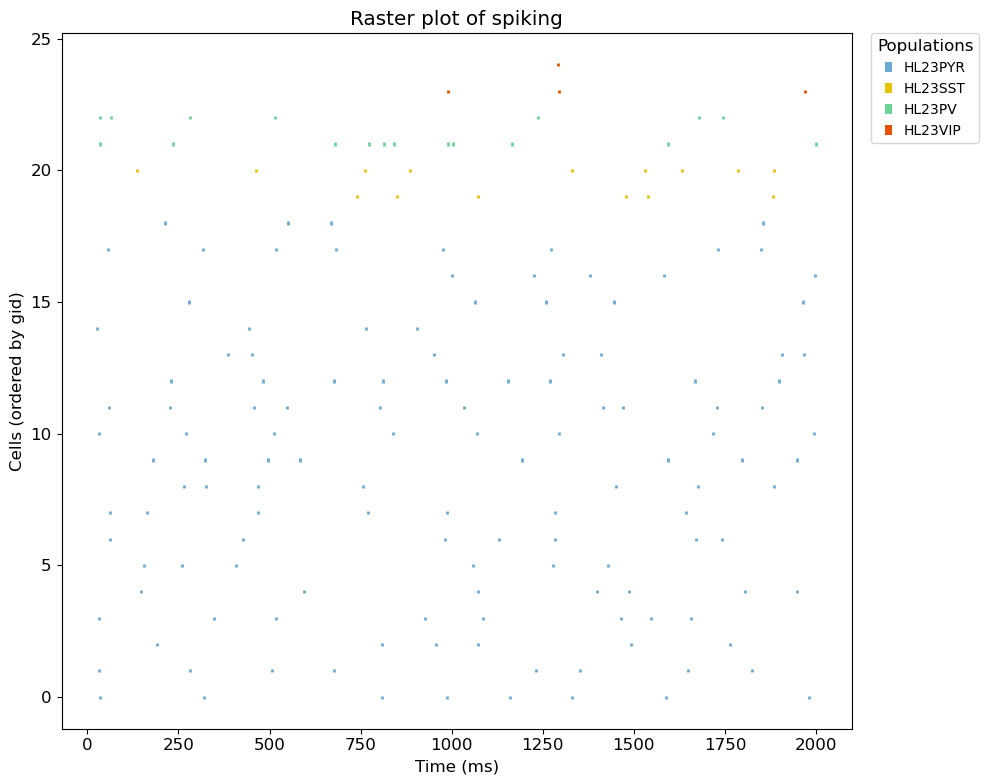

In [20]:
sim.analysis.plotRaster()

Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...


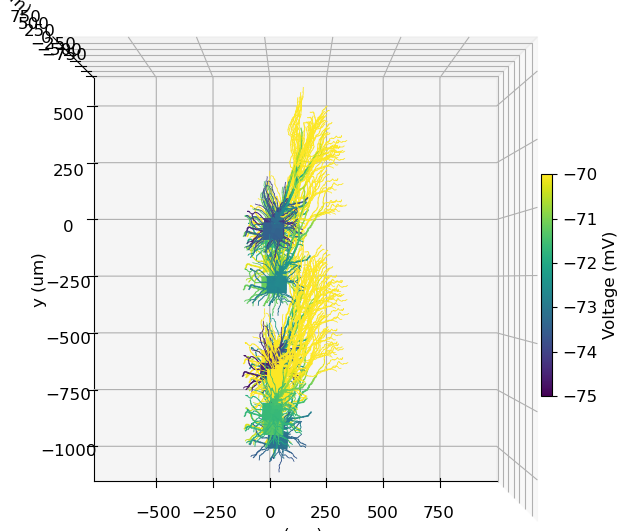

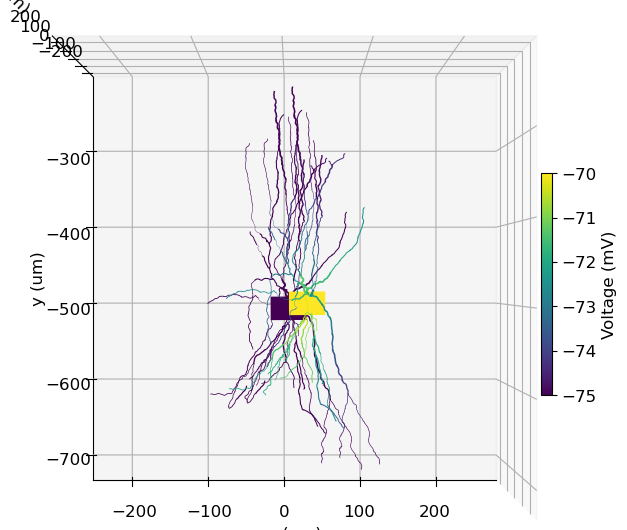

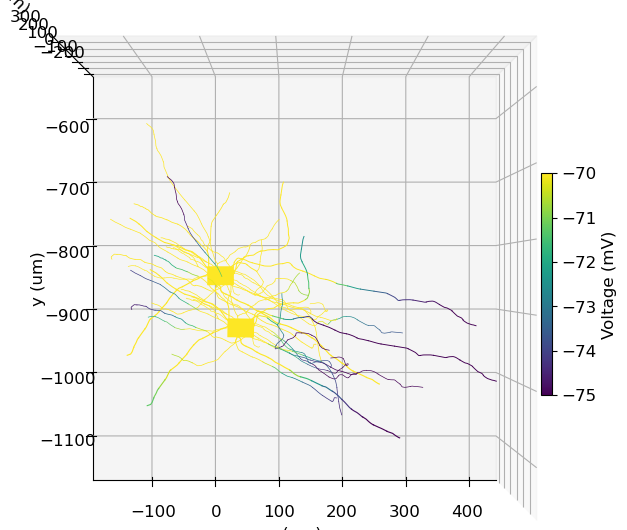

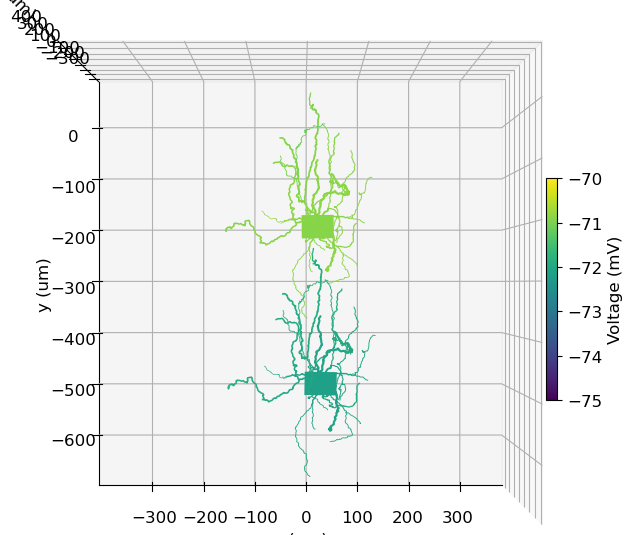

In [21]:
for cn,cell_name in enumerate(['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']):      
# for cn,cell_name in enumerate(['HL23PYR']):               

    sim.analysis.plotShape(includePre=[cell_name], includePost=[cell_name], includeAxon=False, showSyns=False, showElectrodes=False,
        cvar= 'voltage', dist=0.6, elev=90, azim=-90, 
        axisLabels=True, synStyle='o', 
        clim= [-75,-70], showFig=False, synSize=2)

Plotting recorded cell traces ... trace


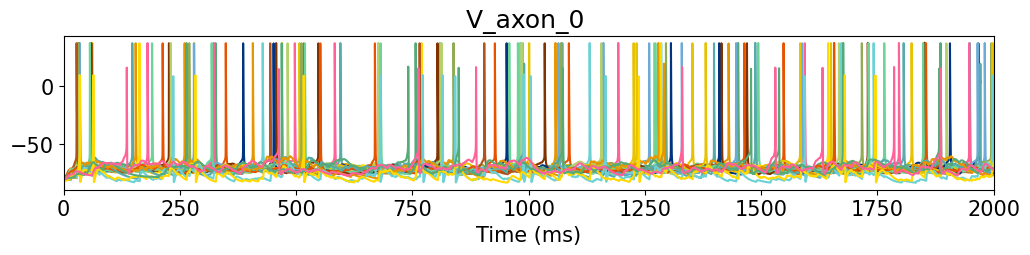

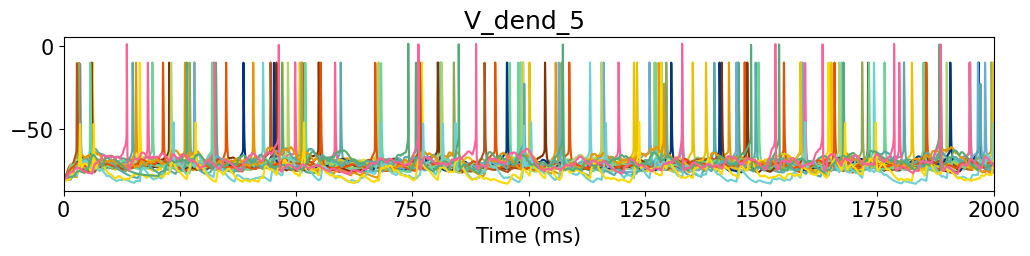

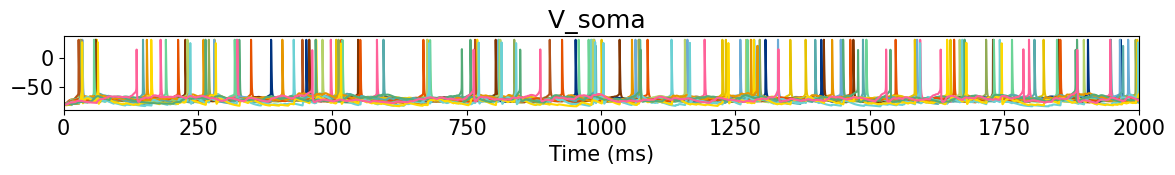

In [22]:
sim.analysis.plotTraces(overlay=True, timeRange=[0,cfg.duration], oneFigPer='trace', figSize=(12,2), fontSize=15, saveFig=False);

In [23]:
# for section in netParams.cellParams['HL23PYR_rule']['secLists']['all']:
#     print(section,'->',netParams.cellParams['HL23PYR_rule']['secs'][section]['topol']['parentSec'])
#     print(section,netParams.cellParams['HL23PYR_rule']['secs'][section]['geom']['diam'],netParams.cellParams['HL23PYR_rule']['secs'][section]['geom']['L'])

Plotting 2D representation of network cell locations and connections...


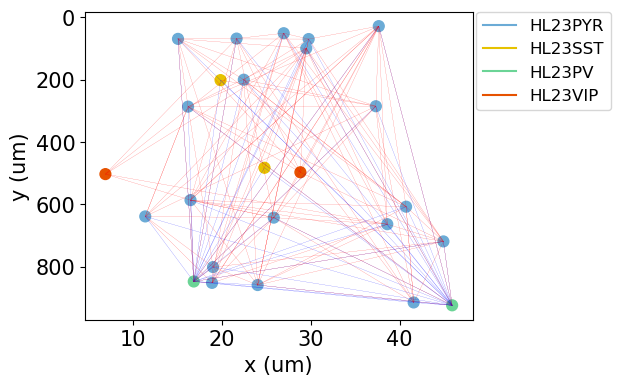

(<Figure size 500x400 with 1 Axes>,
 {'include': ['allCells'],
  'posX': [18.866542109932062,
   25.82154490772423,
   22.443937754455863,
   29.74990490815373,
   41.572888020741296,
   40.72225098109389,
   29.47701860803936,
   16.444473894149688,
   16.166888881615186,
   11.34531341936191,
   37.64583620744247,
   24.003835636981005,
   15.033214250227884,
   26.940053711948174,
   21.63170356749392,
   37.31630814410171,
   44.92442117281967,
   38.600173227575816,
   18.982249253795672,
   19.824196020527303,
   24.775258722406246,
   16.80823824339693,
   45.907116954330235,
   6.858814624564899,
   28.816063530000307],
  'posY': [852.2474281833863,
   642.9374991816148,
   200.41183411366964,
   69.96286864858986,
   915.087317555424,
   607.8313348796611,
   99.75580484612011,
   586.7183329801265,
   286.8399664673861,
   639.0596585722967,
   28.512024523571128,
   859.215238432117,
   69.41032121670192,
   51.24443042994373,
   68.46341151547074,
   285.52776427578004,
   

In [24]:
sim.analysis.plot2Dnet(figSize=(5, 4), fontSize=12)